In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import torch

In [2]:
!pip install httpimport

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import httpimport
remote_url = 'https://raw.githubusercontent.com/kimds929/'

In [4]:
url_path = 'https://raw.githubusercontent.com/kimds929/CodeNote/main/99_DataSet/'
train_df = pd.read_csv(f'{url_path}/NLP_movie_review_train_tokenized.csv', encoding='utf-8-sig')
print(train_df.shape)

(143620, 3)


In [5]:
train_df.sample(5)

,id,label,tokenized
136638,7675450,1,"['힐끆', '힐끆', '힐', '끄다', '요시', '힐링', '대', '쓰다']"
78786,5546784,0,"['일본인', '영화', '만들다', '내', '본', '영화', '중', '사상'..."
135044,9340240,1,"['살', '젊다', '나이', '세상', '을', '떠나다', '영웅', '꼭',..."
70240,10109140,1,"['재미있다', '그리다', '잘생기다']"
44198,8648620,0,"['여자', '명', '나오다', '명', '얼굴', '인간', '같다', '않다'..."


In [6]:
train_X = train_df['tokenized']

In [7]:
with httpimport.remote_repo(f"{remote_url}/DS_Library/main/"):
    from DS_NLP import NLP_Preprocessor

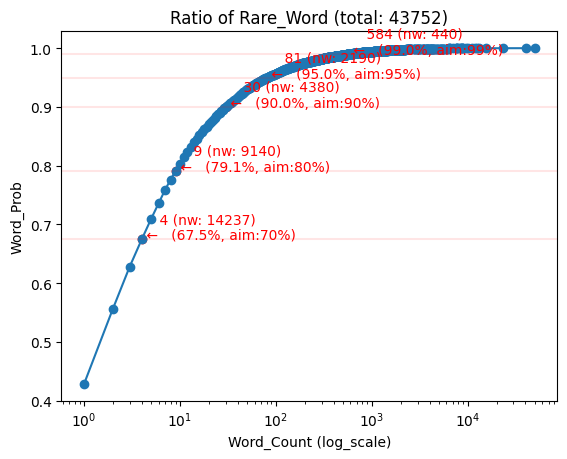

In [8]:
processor = NLP_Preprocessor(texts=train_X)
processor.word_prob()

In [9]:
num_words = 4380
processor = NLP_Preprocessor(texts=train_X)
processor.fit_on_texts(num_words=num_words).texts_to_sequences().add_sos_eos().pad_sequences()
# processor.vocab_size
# processor.word_index
train_y = train_df['label'].to_numpy()[processor.texts_index]
print(processor.texts.shape, train_y.shape)

→ self.texts_texts_to_seq
→ self.texts_add_sos_eos
→ self.texts_pad_seq
(142860, 69) (142860,)


In [10]:
vocab_size = processor.vocab_size
print(vocab_size)

n_cls = 30000

pretrain_X = processor.texts[:-n_cls]
pretrain_y = train_y[:-n_cls]
cls_X = processor.texts[-n_cls:]
cls_y = train_y[-n_cls:]

print(pretrain_X.shape, pretrain_y.shape, cls_X.shape, cls_y.shape)

4383
(112860, 69) (112860,) (30000, 69) (30000,)


In [11]:
with httpimport.remote_repo(f"{remote_url}/DS_Library/main/"):
    from DS_Torch import TorchDataLoader

In [12]:
# pretrain_dataset
pretrain_loader = TorchDataLoader(pretrain_X, pretrain_y, split_size=(0.8,0.1,0.1), random_state=1)
pretrain_loader.make_dataloader(batch_size=64, shuffle=True)
pretrain_loader.dataloader
pretrain_train_loader, pretrain_valid_loader, pretrain_test_loader = pretrain_loader.dataloader
pretrain_sample_X, pretrain_sample_y = pretrain_loader.sample

90288, 11286, 11286, 


In [13]:
# classification_dataset
cls_loader = TorchDataLoader(cls_X, cls_y, split_size=(0.8,0.1,0.1), random_state=1)
cls_loader.make_dataloader(batch_size=64, shuffle=True)
cls_loader.dataloader
cls_train_loader, cls_valid_loader, cls_test_loader = cls_loader.dataloader
cls_sample_X, cls_sample_y = cls_loader.sample

24000, 3000, 3000, 


In [14]:
with httpimport.remote_repo(f"{remote_url}/DS_Library/main/"):
    from DS_TorchModule import EmbeddingLayer, PositionalEncodingLayer, PositionwiseFeedForwardLayer, MultiHeadAttentionLayer, make_tril_mask

In [15]:

# ★★★ GPT1 (Pretrain, DownStream, Fine-Tunnning)
class GPT1(torch.nn.Module):
    def __init__(self, vocab_size, downstream_layer=None, embed_dim=256
                 ,n_layers=1, n_heads=4, posff_dim=512, dropout=0.1, pos_encoding='sinusoid'
                 ,pretrainable=True, downstreamable=True
                 ):
        super().__init__()
        
        # pretrain
        self.gpt_decoder = GPT1_Decoder(vocab_size, embed_dim, n_layers, n_heads, 
                                   posff_dim, dropout, pos_encoding)
        self.projection_layer = torch.nn.Linear(embed_dim, vocab_size, bias=False)
        self.projection_layer.weight = self.gpt_decoder.embed_layer.weight     # We.T
        
        
        # downstream
        if downstream_layer is None:
            self.downstream_layer = NullLayer()
        else:
            self.downstream_layer = downstream_layer
            
        self.pretrainable = True
        self.downstreamable = True
    
    def forward(self, x):
        # GPT1_Decoder
        mask_tril = make_tril_mask(x).unsqueeze(1)
        self.decoder_output = self.gpt_decoder(x, mask_tril)
        with torch.no_grad():
            # self.attention_scores = [layer.attention_score for layer_name, layer in self.decoder.decoder_layers.named_children()]
            self.self_attention_score = self.gpt_decoder.decoder_layers[-1].self_attention_score

        # pretrain 
        if self.pretrainable is True:
            self.pretrain_output = self.projection_layer(self.decoder_output)
            
        # downstream
        if self.downstreamable is True:
            self.downstream_output = self.downstream_layer(self.decoder_output)
        
        # return
        if (self.pretrainable is True) and (self.downstreamable is True):        
            return self.pretrain_output, self.downstream_output
        elif self.pretrainable is True:
            return self.pretrain_output
        elif self.downstreamable is True:
            return self.downstream_output
            
    
    def pretrain(self):
        self.pretrainable = True
        self.downstreamable = False
    
    def downstream(self):
        self.pretrainable = False
        self.downstreamable = True
    
    def fine_tunning(self):
        self.pretrainable = True
        self.downstreamable = True



# GPT1_ClassificationLayer
class GPT1_ClassifierLayer(torch.nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.classifier_lm = torch.nn.Linear(embed_dim, 2, bias=False)
    
    def forward(self, x):
        self.lm_output = self.classifier_lm(x[:,-1, :].contiguous())
        self.output = torch.softmax(self.lm_output, dim=1)
        return self.output

# NullLayer
class NullLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x


# ★★ GPT1_Decoder 
#   gpt = GPT1_Decoder(vocab_size, embed_dim=2, n_heads=1)
#   gpt(sample_X)
#   mask_tril = make_tril_mask(sample_X,0).unsqueeze(1)
#   gpt(sample_X, mask_tril)
class GPT1_Decoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim=256, n_layers=1, n_heads=4, posff_dim=512, dropout=0.1, pos_encoding='sinusoid'):
        super().__init__()
        
        self.embed_layer = EmbeddingLayer(vocab_size, embed_dim)
        self.posembed_layer = PositionalEncodingLayer(pos_encoding)
        self.dropout = torch.nn.Dropout(dropout)

        self.decoder_layers = torch.nn.ModuleList([GPT1_DecoderLayer(embed_dim, n_heads, posff_dim, dropout) for _ in range(n_layers)])
        
    def forward(self, x, mask=None):
        # x : (batch_seq, x_word)
        # mask : (batch_seq, 1, y_word, y_word)

        # embedding layer
        self.x_embed = self.embed_layer(x)  # (batch_seq, x_word, emb)
        
        # positional encoding
        self.x_posembed = self.posembed_layer(self.x_embed)     # (batch_seq, x_word, emb)
        
        # sum of X_emb_scaled and pos_emb_X
        self.x_input = self.dropout(self.x_embed + self.x_posembed)     # (batch_seq, x_word, emb)
        
        # decoder layer
        next_input = self.x_input
        
        for dec_layer in self.decoder_layers:
            next_input = dec_layer(next_input, mask)
        self.decoder_layer_output = next_input

        return self.decoder_layer_output



# ★ GPT1_DecoderLayer
class GPT1_DecoderLayer(torch.nn.Module):
    def __init__(self, embed_dim=256, n_heads=4, posff_dim=512, dropout=0):
        super().__init__()
        self.dropout = torch.nn.Dropout(dropout)
        
        self.self_att_layer = MultiHeadAttentionLayer(embed_dim, n_heads, dropout)
        self.self_att_layer_norm = torch.nn.LayerNorm(embed_dim)
        
        self.posff_layer = PositionwiseFeedForwardLayer(embed_dim, posff_dim, dropout)
        self.posff_layer_norm = torch.nn.LayerNorm(embed_dim)
        
    def forward(self, y_emb, y_mask=None):
        # y_emb : (batch_seq, y_word, emb)
        # X_mask : (batch_seq, 1, ,1, X_word)
        # y_mask : (batch_seq, 1, y_word, y_word)
        
        # (Self Attention Layer) -------------------------------------------------------------------
        self.y_self_att_output = self.self_att_layer((y_emb, y_emb, y_emb), mask=y_mask)
        #  (batch_seq, y_word, fc_dim=emb)        
        self.self_attention_score = self.self_att_layer.attention_score
        # (batch_seq, n_heads, y_word, key_length=y_word)
        
        self.y_skipconnect_1 = y_emb + self.dropout(self.y_self_att_output)   # (batch_seq, y_word, emb)
        # embeding+pos_input 값을 self_attention 결과와 더해준다.
        
        # (Layer Normalization) --------------------------------------------------------------------
        self.y_layer_normed_1 = self.self_att_layer_norm(self.y_skipconnect_1)  # layer normalization
        
        # (Positional FeedForward Layer) -----------------------------------------------------------
        self.y_posff = self.posff_layer(self.y_layer_normed_1)    # (batch_seq, y_word, emb)
        
        # (Layer Normalization) --------------------------------------------------------------------
        self.y_layer_normed_2 = self.posff_layer_norm(self.y_posff)
        # layer_norm_X와 positional_feedforward를 통과한 결과를 더해준다.
        
        return self.y_layer_normed_2   # (batch_seq, y_word, emb)
#######################################################################################################################################


In [16]:
!pip install collection 
!pip install pyperclip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for collection: filename=collection-0.1.6-py3-none-any.whl size=5116 sha256=96d4ce6d49cfc6096a7dfdb7496285f063a2e06f1d63f62f55863a8eba304265
  Stored in directory: /root/.cache/pip/wheels/b8/eb/72/804383af94abbb9ac1893ace85e5620780f0819144486a8bc1
Successfully built collection
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11135 sha256=fcf807a587e0ca2e6847a15ac7efcae899e15c4219eb26605cda16d56063bd54
  Stored in directory: /root/.cache/pip/wheels/0c/09/9e/49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


In [17]:
# Training Setting ########################################################################
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)

# # customize library ***---------------------

class EarlyStopping():
    """
    【 Required Library 】numpy, pandas, matplotlib.pyplot, time, from IPython.display import clear_output
     < Initialize(patience=4, optimize='minimize') >
      . patience: 1,2,3,4 ...
      . optimize: minimize / maximize 
     
     < early_stop(score, save=None, label=None, reference_score=None, reference_save=None, reference_label=None, verbose=0, sleep=0.05, save_all=False) >
      (input)
       . score: metrics_score
       . save: anything that would like to save at optimal point
       . label: plot label
       
       . reference_score: reference metrics score
       . reference_save: reference_save value
       . reference_label: plot reference_label
       
       . verbose: 0, 1, 'plot', 'all'
       . sleep: when plotting, sleeping time(seconds).
       . save_all:
     
    """
    def __init__(self, patience=4, optimize='miminize'):
        self.patience = np.inf if patience is None else patience
        self.optimize = optimize
        
        self.metrics = []       # (epoch, event, score, save, r_score, r_save)
        self.metrics_frame = pd.DataFrame()
        self.patience_scores = []
        self.optimum = (0, np.inf if 'min' in optimize else -np.inf, '', None, None)    # (epoch, score, save, r_score, r_save)
    
    def reset_patience_scores(self):
        self.patience_scores = []
    
    def early_stop(self, score, save=None, label=None,
                   reference_score=None, reference_save=None, reference_label=None,
                   verbose=0, sleep=0, save_all=False):
        
        result = 'none'
        epoch = len(self.metrics)+1
        label_score = 'valid_score' if label is None else label
        label_r_score = 'train_score' if reference_label is None else reference_label
        
        if 'min' in self.optimize:
            if score < self.optimum[1]:     # optimum
                self.patience_scores = []
                result = 'optimum'
            else:
                self.patience_scores.append(score)
                if len(self.patience_scores) > self.patience:
                    result = 'break'
                else:
                    result = 'patience'
        elif 'max' in self.optimize:
            if score > self.optimum[1]:     # optimum
                self.patience_scores = []
                result = 'optimum'
            else:
                self.patience_scores.append(score)
                if len(self.patience_scores) > self.patience:
                    result = 'break'
                else:
                    result = 'patience'
        
        # state save
        state = (epoch, result, score, save, reference_score, reference_save) if (save_all is True or result == 'optimum') else (epoch, result, score, '', reference_score, '')
        self.metrics.append(state)

        # update state metrics
        if result == 'optimum':
            if  self.optimum[0] > 0:
                prev_optim_index = self.metrics.index( list(filter(lambda x: x[0]==self.optimum[0], self.metrics))[0] )
                if save_all is True:
                    self.metrics[prev_optim_index] = tuple( ('none' if ei==1 else element) for ei, element in enumerate(self.metrics[prev_optim_index]) )
                else:
                    self.metrics[prev_optim_index] = tuple( ('none' if ei==1 else ('' if ei in [3,5] else element) ) for ei, element in enumerate(self.metrics[prev_optim_index]) )
            self.optimum = (epoch, score, save, reference_score, reference_save)
        
        # metrics_frame = pd.concat([self.metrics_frame, pd.Series(state, index=['epoch', 'event', label_score, 'save', 'r_score', 'r_save'], name=len(self.metrics_frame)).to_frame().T], axis=0)
        metrics_frame = pd.DataFrame(self.metrics, columns=['epoch', 'event', label_score, 'save', label_r_score, 'r_save'])
        metrics_frame['event'] = pd.Categorical(metrics_frame['event'], categories=['none', 'patience', 'break', 'optimum'], ordered=True)
        metrics_frame[label_score] = metrics_frame[label_score].astype('float')
        metrics_frame[label_r_score] = metrics_frame[label_r_score].astype('float')
        
        # plot        
        if verbose == 'plot' or verbose=='all':
            clear_output(wait=True)
        self.plot = plt.figure()
        
        # reference_score
        if reference_score is not None:
            plt.plot(metrics_frame['epoch'], metrics_frame[label_r_score], 'o-', alpha=0.5, color='orange', label=label_r_score)
            
        plt.plot(metrics_frame['epoch'], metrics_frame[label_score], alpha=0.5, color='steelblue', label=label_score)
        plt.legend(loc='upper right')
        
        metrics_colors = ['steelblue', 'gold', 'red', 'green']
        for me, (mgi, mgv) in enumerate(metrics_frame.groupby('event')):
            plt.scatter(mgv['epoch'], mgv[label_score], color=metrics_colors[me])            
        for mi, mg in metrics_frame[metrics_frame['event'] != ''].iterrows():
            event_name = 'p' if mg['event'] == 'patience' else ('★' if mg['event']=='optimum' else ('break' if mg['event'] == 'break' else ''))
            plt.text(mg['epoch'], mg[label_score], event_name)
        plt.xlabel('epoch')
        plt.ylabel('score')
        # plt.yscale('symlog')
        if verbose == 'plot' or verbose=='all':
            plt.show()
            time.sleep(sleep)
        else:
            plt.close()
        
        # print state
        if (type(verbose)==int and verbose > 1) or verbose=='all':
            if (verbose in ['plot', 'all']) and result != 'optimum':
                print(f"(Optimum) epoch: {self.optimum[0]}, {label_score}: {str(self.optimum[1])[:6]}, {label_r_score}: {str(self.optimum[3])[:6]}")
            
            if reference_score is not None:
                print(f"epoch: {len(self.metrics)}, {label_score}: {str(score)[:6]}, {label_r_score}: {str(reference_score)[:6]} {f'**{result}' if result != 'none' else ''}")
            else:
                print(f"epoch: {len(self.metrics)}, {label_score}: {str(score)[:6]} {f'**{result}' if result != 'none' else ''}")
        elif verbose == 1:
            if result != 'break':
                print(epoch, end=' ')
            else:
                print(epoch, end=' *break\n')
                print(f"(Optimum) epoch: {self.optimum[0]}, {label_score}: {str(self.optimum[1])[:6]}, {label_r_score}: {str(self.optimum[3])[:6]}") 
        
        self.metrics_frame = metrics_frame.copy()
        return result

# # ------------------------------------------
import time
import copy

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def torch_accuracy_score(dataloader, estimator, device='cpu', verbose=0):
    estimator.eval()
    with torch.no_grad():
        acc_list = []

        for batch in dataloader:
            batch_X = batch[0].type(torch.long).to(device)
            batch_y = batch[1].to(device)
            
            pred = estimator(batch_X)
            pred_cls = torch.argmax(pred, axis=1).to('cpu').detach().numpy()
            real_cls = batch_y.to('cpu').detach().numpy()
            acc_list.append((pred_cls == real_cls))
        acc_array = np.hstack(acc_list)
        test_accuracy = acc_array.sum()/len(acc_array)
        if verbose > 0:
            print(test_accuracy)
    return test_accuracy

cuda:0


In [18]:
# Classification without pre-training ########################################################################
print('* Classification without pre-training ----------------------------------------------------------------')
gpt_cls = GPT1(vocab_size, GPT1_ClassifierLayer(), n_layers=3).to(device)
gpt_cls.downstream()
# gpt_cls(cls_sample_X)     # (64, 2)
# gpt_cls(cls_sample_X).shape

model = copy.deepcopy(gpt_cls)


# # model weights parameter initialize (가중치 초기화) ***
# def init_weights(model):
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             torch.nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             torch.nn.init.constant_(param.data, 0)
# model.apply(init_weights)


es = EarlyStopping(patience=100)
loss_function = torch.nn.CrossEntropyLoss()

# learning_rate = 0.001
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100


* Classification without pre-training ----------------------------------------------------------------


In [19]:

# training * -------------------------------------------------------------------------------------------------------
train_loader = cls_train_loader
valid_loader = cls_valid_loader
test_loader = cls_test_loader

train_losses = []
valid_losses = []
for e in range(epochs):
    start_time = time.time() # 시작 시간 기록
    # train_set learning*
    model.train()
    train_epoch_loss = []
    for batch  in train_loader:
        batch_X = batch[0].type(torch.long).to(device)
        batch_y = batch[1].to(device)
        optimizer.zero_grad()                   # wegiht initialize
        model(batch_X)                          # forward
        pred = model.downstream_output          # predict
        loss = loss_function(pred, batch_y)     # loss
        loss.backward()                         # backward
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)    # 기울기(gradient) clipping 진행
        # (gradient clipping) https://sanghyu.tistory.com/87
        optimizer.step()                        # update_weight

        with torch.no_grad():
            train_batch_loss = loss.to('cpu').detach().numpy()
            train_epoch_loss.append( train_batch_loss )
    

    # valid_set evaluation *
    valid_epoch_loss = []
    with torch.no_grad():
        model.eval() 
        for batch in valid_loader:
            batch_X = batch[0].to(device)
            batch_y = batch[1].to(device)
            model(batch_X)                          # forward
            pred = model.downstream_output          # predict
            loss = loss_function(pred, batch_y)     # loss
            valid_batch_loss = loss.to('cpu').detach().numpy()
            valid_epoch_loss.append( valid_batch_loss )

    with torch.no_grad():
        train_loss = np.mean(train_epoch_loss)
        valid_loss = np.mean(valid_epoch_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time() # 종료 시간 기록
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):.3f}')
        # print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {np.exp(valid_loss):.3f}')

        # # customize library ***---------------------
        early_stop = es.early_stop(score=valid_loss, reference_score=train_loss, save=model.state_dict(), verbose=2)
        if early_stop == 'break':
            break
        # # ------------------------------------------
# --------------------------------------------------------------------------------------------------------------------

epoch: 1, valid_score: 0.5991, train_score: 0.6706 **optimum
epoch: 2, valid_score: 0.5583, train_score: 0.5843 **optimum
epoch: 3, valid_score: 0.5372, train_score: 0.5520 **optimum
epoch: 4, valid_score: 0.5315, train_score: 0.5347 **optimum
epoch: 5, valid_score: 0.5376, train_score: 0.5221 **patience
epoch: 6, valid_score: 0.5178, train_score: 0.5132 **optimum
epoch: 7, valid_score: 0.5173, train_score: 0.5068 **optimum
epoch: 8, valid_score: 0.5139, train_score: 0.4996 **optimum
epoch: 9, valid_score: 0.5122, train_score: 0.4961 **optimum
epoch: 10, valid_score: 0.5036, train_score: 0.4927 **optimum
epoch: 11, valid_score: 0.5055, train_score: 0.4887 **patience
epoch: 12, valid_score: 0.5104, train_score: 0.4860 **patience
epoch: 13, valid_score: 0.5064, train_score: 0.4829 **patience
epoch: 14, valid_score: 0.5040, train_score: 0.4796 **patience
epoch: 15, valid_score: 0.5074, train_score: 0.4757 **patience
epoch: 16, valid_score: 0.5087, train_score: 0.4751 **patience
epoch: 17,

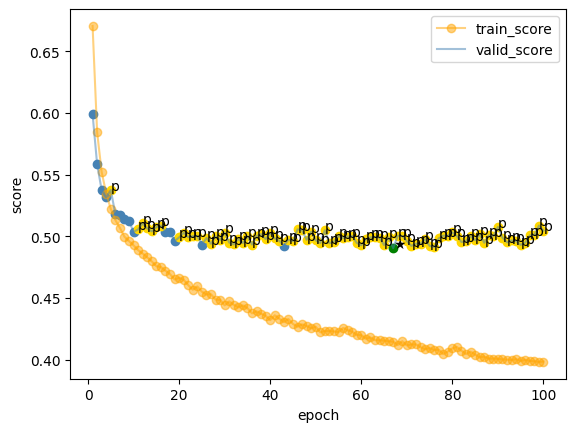

In [20]:
# customize library ***---------------------
es.plot     # early_stopping plot
# ------------------------------------------

In [21]:
gpt_cls.load_state_dict(es.optimum[2])    # optimum model (load weights)

<All keys matched successfully>

In [22]:
# Performance Evaluate (Accuracy_score)
torch_accuracy_score(cls_valid_loader, gpt_cls, device)

0.8053333333333333

In [23]:
# Classification with pre-training ########################################################################

In [24]:

# Pre-training ★ #########
print('* Classification with pre-training : pre-training ----------------------------------------------------------------')
# sample_X.shape    # (64, 69)
gpt_pretain = GPT1(vocab_size, n_layers=3).to(device)
gpt_pretain.pretrain()
# gpt_pretain(cls_sample_X)  # (64, 69, 4383)
# gpt_pretain(cls_sample_X).shape

model = copy.deepcopy(gpt_pretain)

# # model weights parameter initialize (가중치 초기화) ***
# def init_weights(model):
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             torch.nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             torch.nn.init.constant_(param.data, 0)
# model.apply(init_weights)

es = EarlyStopping(patience=100)

# loss_function = torch.nn.CrossEntropyLoss()     # ignore_index=trg_pad_idx
learning_rate = 5e-5
loss_function = torch.nn.CrossEntropyLoss(ignore_index=0)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100


* Classification with pre-training : pre-training ----------------------------------------------------------------


In [25]:

# training * -------------------------------------------------------------------------------------------------------
train_loader = pretrain_train_loader
valid_loader = pretrain_valid_loader
test_loader = pretrain_test_loader


train_losses = []
valid_losses = []
for e in range(epochs):
    start_time = time.time() # 시작 시간 기록
    # train_set learning*
    model.train()
    train_epoch_loss = []
    for batch  in train_loader:
        batch_X = batch[0].type(torch.long).to(device)
        optimizer.zero_grad()                   # wegiht initialize
        model(batch_X)                          # forward
        pred_eval = model.pretrain_output[:,:-1,:].reshape(-1, vocab_size)  # self-supervised predict
        real_eval = batch_X[:,1:].reshape(-1)
         
        loss = loss_function(pred_eval, real_eval)     # loss
        loss.backward()                         # backward
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)    # 기울기(gradient) clipping 진행
        # (gradient clipping) https://sanghyu.tistory.com/87
        optimizer.step()                        # update_weight

        with torch.no_grad():
            train_batch_loss = loss.to('cpu').detach().numpy()
            train_epoch_loss.append( train_batch_loss )
    

    # valid_set evaluation *
    valid_epoch_loss = []
    with torch.no_grad():
        model.eval() 
        for batch in valid_loader:
            batch_X = batch[0].type(torch.long).to(device)
            model(batch_X)                   # forward
            pred_eval = model.pretrain_output[:,:-1,:].reshape(-1, vocab_size)  # self-supervised predict
            real_eval = batch_X[:,1:].reshape(-1)

            loss = loss_function(pred_eval, real_eval)     # loss
            valid_batch_loss = loss.to('cpu').detach().numpy()
            valid_epoch_loss.append( valid_batch_loss )

    with torch.no_grad():
        train_loss = np.mean(train_epoch_loss)
        valid_loss = np.mean(valid_epoch_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time() # 종료 시간 기록
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):.3f}')
        # print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {np.exp(valid_loss):.3f}')

        # # customize library ***---------------------
        early_stop = es.early_stop(score=valid_loss, reference_score=train_loss, save=model.state_dict(), verbose=2)
        if early_stop == 'break':
            break
        # # ------------------------------------------
# --------------------------------------------------------------------------------------------------------------------


epoch: 1, valid_score: 9.9407, train_score: 14.807 **optimum
epoch: 2, valid_score: 8.2686, train_score: 7.7362 **optimum
epoch: 3, valid_score: 7.9854, train_score: 6.1326 **optimum
epoch: 4, valid_score: 7.2185, train_score: 5.3986 **optimum
epoch: 5, valid_score: 7.1935, train_score: 4.9716 **optimum
epoch: 6, valid_score: 6.6975, train_score: 4.7053 **optimum
epoch: 7, valid_score: 6.7817, train_score: 4.5124 **patience
epoch: 8, valid_score: 6.5099, train_score: 4.3659 **optimum
epoch: 9, valid_score: 6.1280, train_score: 4.2427 **optimum
epoch: 10, valid_score: 6.1915, train_score: 4.1368 **patience
epoch: 11, valid_score: 5.8248, train_score: 4.041 **optimum
epoch: 12, valid_score: 5.6502, train_score: 3.9563 **optimum
epoch: 13, valid_score: 5.3264, train_score: 3.8704 **optimum
epoch: 14, valid_score: 5.1459, train_score: 3.7831 **optimum
epoch: 15, valid_score: 4.7571, train_score: 3.6811 **optimum
epoch: 16, valid_score: 4.4236, train_score: 3.5595 **optimum
epoch: 17, valid

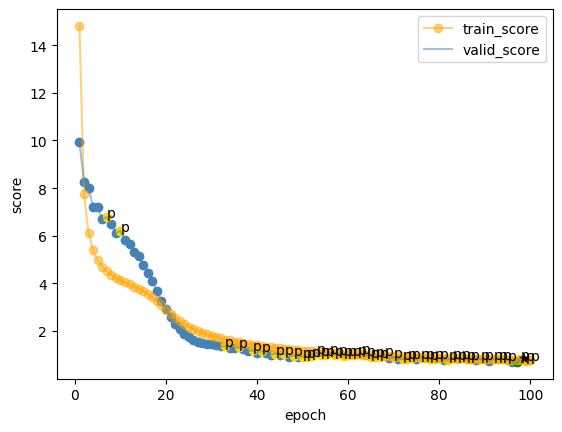

In [26]:
# customize library ***---------------------
es.plot     # early_stopping plot
# ------------------------------------------

In [27]:
gpt_pretain.load_state_dict(es.optimum[2])    # optimum model (load weights)

<All keys matched successfully>

In [28]:
# Transfer Learning & Fine-Tunning for Classification ★ #########################################################
print('* Classification with pre-training : fine-tunning (classification downstream) ----------------------------')

gpt_cls_with_pretrain = GPT1(vocab_size, GPT1_ClassifierLayer(), n_layers=3).to(device)
gpt_cls_with_pretrain.fine_tunning()
# gpt_cls_with_pretrain(cls_sample_X)       # (64, 25, 2160), (64, 2)

# parameter transfer ★★★
gpt_cls_with_pretrain.gpt_decoder.load_state_dict(gpt_pretain.gpt_decoder.state_dict())


model = copy.deepcopy(gpt_cls_with_pretrain)

# # model weights parameter initialize (가중치 초기화) ***
# def init_weights(model):
#     for name, param in model.named_parameters():
#         if 'weight' in name:
#             torch.nn.init.normal_(param.data, mean=0, std=0.01)
#         else:
#             torch.nn.init.constant_(param.data, 0)
# model.apply(init_weights)


es = EarlyStopping(patience=100)
loss_function = torch.nn.CrossEntropyLoss()

# learning_rate = 0.001
learning_rate = 5e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 100


lamb = 0.5


* Classification with pre-training : fine-tunning (classification downstream) ----------------------------


In [29]:

# training * -------------------------------------------------------------------------------------------------------
train_loader = cls_train_loader
valid_loader = cls_valid_loader
test_loader = cls_test_loader

train_losses = []
valid_losses = []
for e in range(epochs):
    start_time = time.time() # 시작 시간 기록
    # train_set learning*
    model.train()
    train_epoch_loss = []
    for ei, batch  in enumerate(train_loader):
        batch_X = batch[0].type(torch.long).to(device)
        batch_y = batch[1].to(device)
        
        optimizer.zero_grad()                   # wegiht initialize
        pred_pretrain, pred_cls = model(batch_X)                   # forward
        # loss_function for GPT fine-tunning ----------------------------------------
        # Loss_L1
        pretrain_pred_eval = pred_pretrain[:,:-1,:].reshape(-1, vocab_size)
        pretrain_real_eval = batch_X[:,1:].reshape(-1)
        loss_L1 = loss_function(pretrain_pred_eval, pretrain_real_eval)     # loss

        # Loss_L2
        loss_L2 = loss_function(pred_cls, batch_y)     # loss

        # Loss = L2 + λ·L1
        loss = loss_L2 + lamb * loss_L1
        loss.backward()                         # backward
        # ------------------------------------------------------------------------------
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)    # 기울기(gradient) clipping 진행
        # (gradient clipping) https://sanghyu.tistory.com/87
        optimizer.step()                        # update_weight

        with torch.no_grad():
            train_batch_loss = loss.to('cpu').detach().numpy()
            train_epoch_loss.append( train_batch_loss )

    # valid_set evaluation *
    valid_epoch_loss = []
    with torch.no_grad():
        model.eval() 
        for batch in valid_loader:
            batch_X = batch[0].type(torch.long).to(device)
            batch_y = batch[1].to(device)
            
            pred_pretrain, pred_cls = model(batch_X)                   # forward
            # loss_function for GPT fine-tunning ----------------------------------------
            # Loss_L1
            pretrain_pred_eval = pred_pretrain[:,:-1,:].reshape(-1, vocab_size)
            pretrain_real_eval = batch_X[:,1:].reshape(-1)
            loss_L1 = loss_function(pretrain_pred_eval, pretrain_real_eval)     # loss

            # Loss_L2
            loss_L2 = loss_function(pred_cls, batch_y)     # loss

            # Loss = L2 + λ·L1
            loss = loss_L2 + lamb * loss_L1
            # ------------------------------------------------------------------------------
            valid_batch_loss = loss.to('cpu').detach().numpy()
            valid_epoch_loss.append( valid_batch_loss )

    with torch.no_grad():
        train_loss = np.mean(train_epoch_loss)
        valid_loss = np.mean(valid_epoch_loss)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time() # 종료 시간 기록
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        # print(f'Epoch: {e + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
        # print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):.3f}')
        # print(f'\tValidation Loss: {valid_loss:.3f} | Validation PPL: {np.exp(valid_loss):.3f}')

        # # customize library ***---------------------
        early_stop = es.early_stop(score=valid_loss, reference_score=train_loss, save=model.state_dict(), verbose=2)
        if early_stop == 'break':
            break
        # # ------------------------------------------
# --------------------------------------------------------------------------------------------------------------------


epoch: 1, valid_score: 0.6279, train_score: 0.8314 **optimum
epoch: 2, valid_score: 0.5946, train_score: 0.6527 **optimum
epoch: 3, valid_score: 0.5919, train_score: 0.6296 **optimum
epoch: 4, valid_score: 0.5684, train_score: 0.6154 **optimum
epoch: 5, valid_score: 0.5667, train_score: 0.6067 **optimum
epoch: 6, valid_score: 0.5672, train_score: 0.5954 **patience
epoch: 7, valid_score: 0.5573, train_score: 0.5905 **optimum
epoch: 8, valid_score: 0.5590, train_score: 0.5854 **patience
epoch: 9, valid_score: 0.5617, train_score: 0.5813 **patience
epoch: 10, valid_score: 0.5609, train_score: 0.5805 **patience
epoch: 11, valid_score: 0.5639, train_score: 0.5735 **patience
epoch: 12, valid_score: 0.5625, train_score: 0.5652 **patience
epoch: 13, valid_score: 0.5486, train_score: 0.5616 **optimum
epoch: 14, valid_score: 0.5547, train_score: 0.5589 **patience
epoch: 15, valid_score: 0.5451, train_score: 0.5566 **optimum
epoch: 16, valid_score: 0.5487, train_score: 0.5551 **patience
epoch: 17

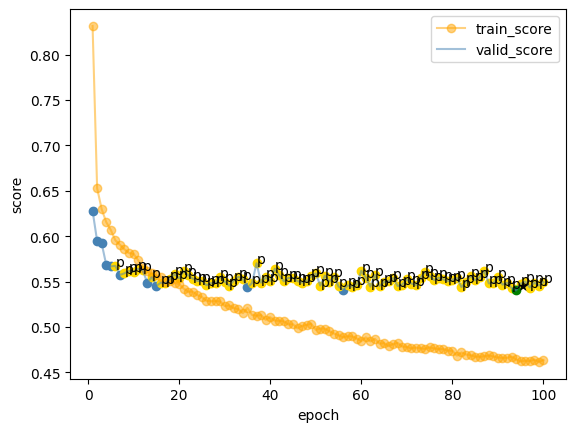

In [30]:
# customize library ***---------------------
es.plot     # early_stopping plot
# ------------------------------------------

In [31]:
gpt_cls_with_pretrain.load_state_dict(es.optimum[2])    # optimum model (load weights)

<All keys matched successfully>

In [32]:
# Performance Evaluate (Accuracy_score)
gpt_cls_with_pretrain.downstream()
torch_accuracy_score(cls_test_loader, gpt_cls_with_pretrain, device)

0.8066666666666666

In [33]:
# Compare Performance ###########################################################
torch_accuracy_score(cls_valid_loader, gpt_cls, device, verbose=1)
torch_accuracy_score(cls_test_loader, gpt_cls_with_pretrain, device, verbose=1)
print()

0.8053333333333333
0.8066666666666666

